#### Explainability: SHAP (global and local) & LIME(instance level)

This notebook performs explainability analysis for models trained on the Statlog (German Credit) dataset.

The objective is to understand:
- Which features drive credit risk predictions?
- How individual decisions are made?
- Whether the model behaves reasonably and fairly?

Note: 0 is bad credit and 1 is good credit

In [1]:
# Importing necessary libraries
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
# Setting random seed for reproducibility
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

d:\MambaForge-Mini\envs\project_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ensuring model directory exists
assert os.path.exists("models"), "models/ directory not found. Save pipelines and feature_names there first."

In [3]:
# Loading feature names
feature_names = joblib.load("models/feature_names.joblib")
# Loading models
rf_pipeline = joblib.load("models/random_forest_pipeline.joblib")
xgb_pipeline = joblib.load("models/xgboost_pipeline.joblib")
dt_pipeline = joblib.load("models/decision_tree_pipeline.joblib")
lr_pipeline = joblib.load("models/logistic_regression_pipeline.joblib")
# Checking if the models are loaded correctly
print("loaded models:", type(rf_pipeline), '\n', type(xgb_pipeline),'\n', type(lr_pipeline),'\n', type(dt_pipeline))
print("loaded feature names:", feature_names)
# Loading test data
X_test = pd.read_csv("models/X_test.csv")
y_test = pd.read_csv("models/y_test.csv").values.ravel()
# Checking the shape of test data
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

loaded models: <class 'sklearn.pipeline.Pipeline'> 
 <class 'sklearn.pipeline.Pipeline'> 
 <class 'sklearn.pipeline.Pipeline'> 
 <class 'sklearn.pipeline.Pipeline'>
loaded feature names: ['Duration', 'Credit_amount', 'Installment_rate', 'Residence_since', 'Age', 'Number_existing_credits', 'Number_people_liable', 'Status_checking_0 <= balance < 200 DM', 'Status_checking_< 0 DM', 'Status_checking_>= 200 DM / salary assigned >= 1 year', 'Status_checking_No checking account', 'Credit_history_All credits at this bank paid back duly', 'Credit_history_Critical account / other credits existing', 'Credit_history_Delay in paying off in the past', 'Credit_history_Existing credits paid back duly till now', 'Credit_history_No credits taken / all credits paid back duly', 'Purpose_Business', 'Purpose_Car (new)', 'Purpose_Car (used)', 'Purpose_Domestic appliances', 'Purpose_Education', 'Purpose_Furniture / equipment', 'Purpose_Others', 'Purpose_Radio / television', 'Purpose_Repairs', 'Purpose_Retraini

In [ ]:
# Extracting individual model components from pipelines
def extract_model_and_preprocessor(pipeline):
    preprocessor = pipeline.named_steps['preprocessing']
    model = pipeline.named_steps['model']
    return preprocessor, model

In [5]:
rf_preproc, rf_model = extract_model_and_preprocessor(rf_pipeline)
xgb_preproc, xgb_model = extract_model_and_preprocessor(xgb_pipeline)
dt_preproc, dt_model = extract_model_and_preprocessor(dt_pipeline)
lr_preproc, lr_model = extract_model_and_preprocessor(lr_pipeline)

In [6]:
rf_model

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [ ]:
print(f"RF has {rf_model.n_estimators} trees.")
# Transforming test data
X_test_transformed = rf_preproc.transform(X_test)
feature_names_transformed = rf_preproc.get_feature_names_out()
print(f"No of features after preprocessing: {len(feature_names_transformed)}")
# Converting transformed data to df
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names_transformed)
X_test_df.head()
# SHAP tree explainer for Random Forest
explainer = shap.TreeExplainer(rf_model)
# Average prediction across the test set
print(f"Expected value RF: Good Credit {explainer.expected_value[1]}, Bad Credit {explainer.expected_value[0]}")
# Computing SHAP values
shap_values = explainer.shap_values(X_test_df)
print(f"SHAP values shape: {shap_values.shape}")
# SHAP for good credit class (1)
shap_values_class1 = shap_values[:, :, 1]
shap_values_class1.shape
# SHAP for bad credit class (0)
shap_values_class0 = shap_values[:, :, 0]
shap_values_class0.shape

RF has 200 trees.
No of features after preprocessing: 58
Expected value RF: Good Credit 0.6986750000000007, Bad Credit 0.30132500000000007
SHAP values shape: (200, 58, 2)


(200, 58)

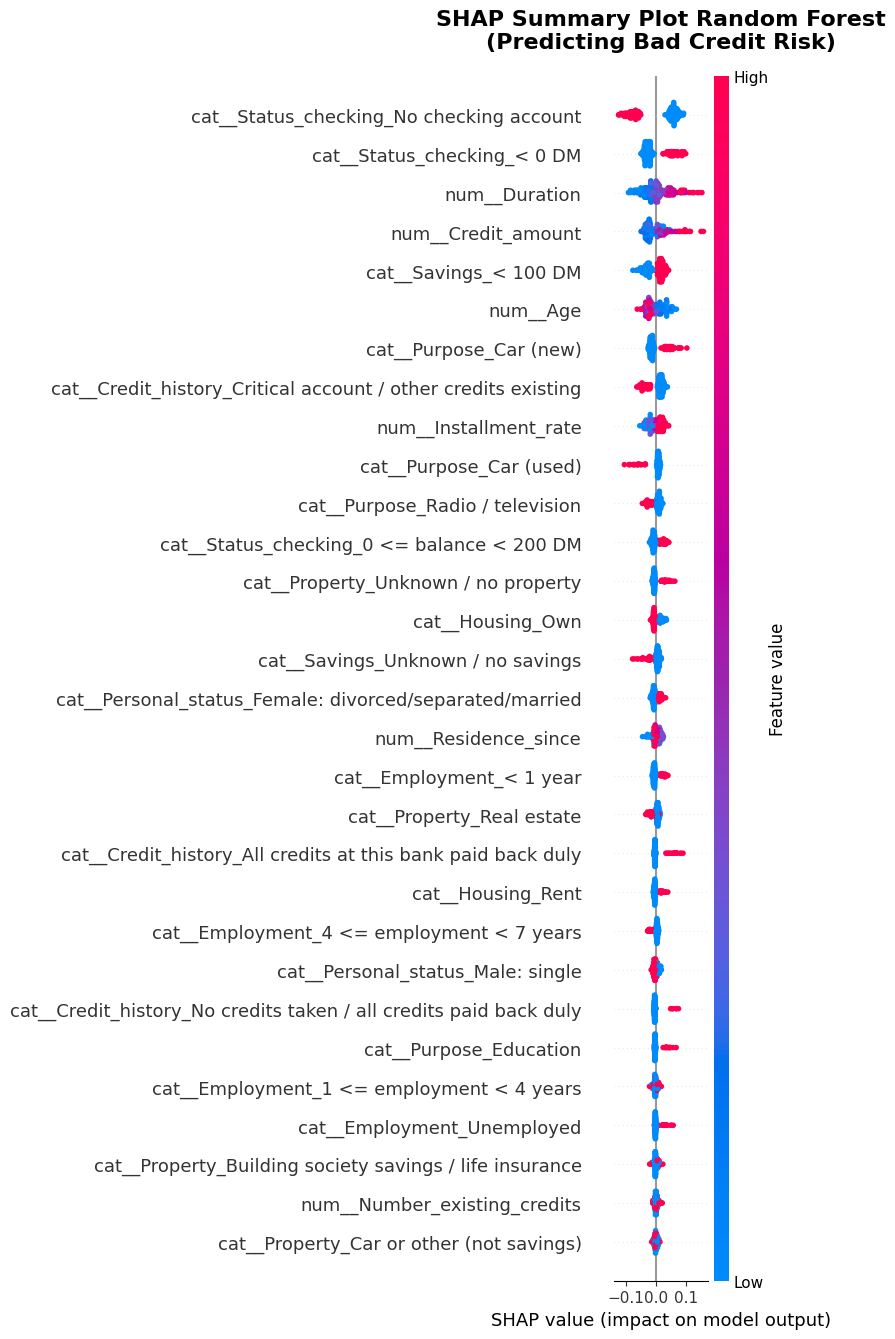

In [8]:
# SHAP summary plot for Random Forest - Bad Credit Risk
plt.figure(figsize=(14, 16))
shap.summary_plot(
    shap_values_class0,      
    X_test_df,
    max_display=30,          
    show=False
)
plt.title('SHAP Summary Plot Random Forest\n(Predicting Bad Credit Risk)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

- Most influential features were no checking amount (which increases bad credit risk), negative checking balance (<0 DM) and low positive balance indicating that **lack of liquidity is the strongest signal of financial instability.**
- Longer loan durations and higher loan amounts increase the likelihood of bad credit.
- When savings are <100 DM or no savings model leans towards bad credit risk.
- Older applicants tend to have lower risk but age has a secondary effect.
- Past repayment behavior is a reliable predictor of future default.


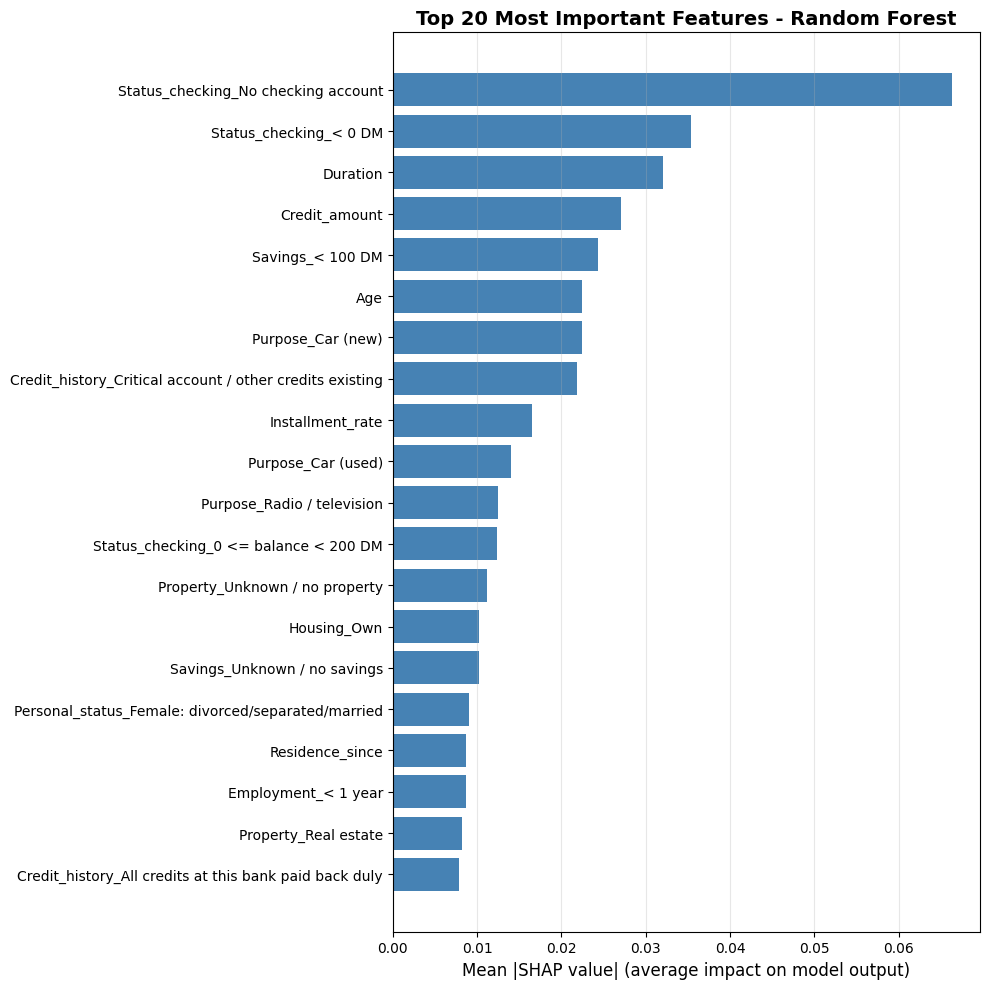

In [9]:
mean_abs_shap = np.abs(shap_values_class0).mean(axis=0)
# Creating a df to store feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=True)
plt.figure(figsize=(10, 10))
top_features = feature_importance_df.tail(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Mean |SHAP value| (average impact on model output)', fontsize=12)
plt.title('Top 20 Most Important Features - Random Forest', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

- RF model identifies bad credit risk mainly from financial stability signals with no checking account, negative balance, loan duration and credit amount having strongest impact on predictions.
- Secondary factors like age, loan purpose and credit history refine the risk assessment but matter less than core banking and loan characteristics.

Sample number 15
Actual label: 1
Model prediction: 1
Prediction probability: [0.38 0.62]


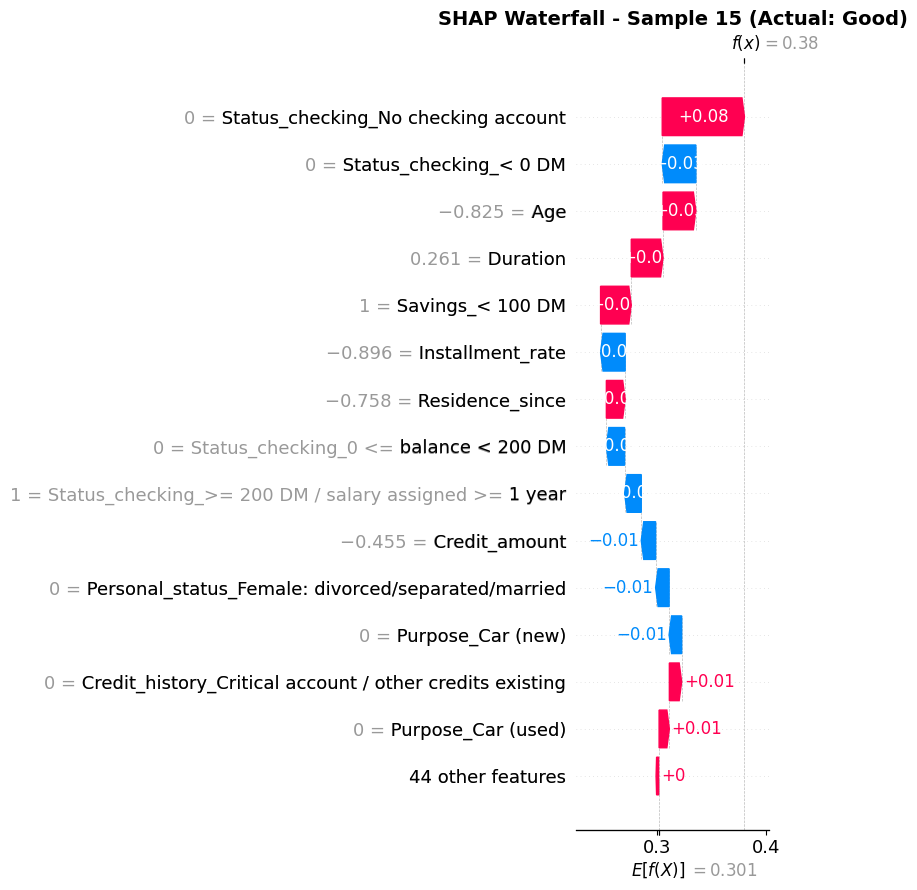

In [10]:
# Choosing a sample to view factors influencing prediction
sample_idx = 15
print(f"Sample number {sample_idx}")
print(f"Actual label: {y_test[sample_idx]}")
print(f"Model prediction: {rf_model.predict(X_test_df.iloc[[sample_idx]])[0]}")
print(f"Prediction probability: {rf_model.predict_proba(X_test_df.iloc[[sample_idx]])[0]}")
plt.figure(figsize=(10, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_class0[sample_idx],
        base_values=explainer.expected_value[0],
        data=X_test_df.iloc[sample_idx].values,
        feature_names=list(feature_names)
    ),
    max_display=15,
    show=False
)
plt.title(f'SHAP Waterfall - Sample {sample_idx} (Actual: {"Bad" if y_test[sample_idx]==0 else "Good"})', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

- For Sample 15 the model predicts Good Credit with a moderate confidence as risk increasing factors are present but not strong enough to outweigh protective signals.
- Positive banking status, manageable credit amount, and stable installment behavior reduce overall risk, keeping the prediction on the good-credit side.
- In conclusion this customer shows mixed risk signals, but the protective factors slightly dominate leading to a correct but less confident good credit prediction.

Moving onto LIME for Random Forest to understand how model behaves locally around one applicant to answer:
-  Which features mattered most for this single decision?
-  Whether small changes could flip the outcome

In [11]:
# Now creating LIME explainer for RF
lime_explainer = LimeTabularExplainer(
    training_data=X_test_transformed,
    feature_names=list(feature_names),
    class_names=['Good Credit', 'Bad Credit'],
    mode='classification',
    random_state=42
)

Sample number 15
Actual label: 1
Model prediction: 1
Prediction probability: [0.38 0.62]


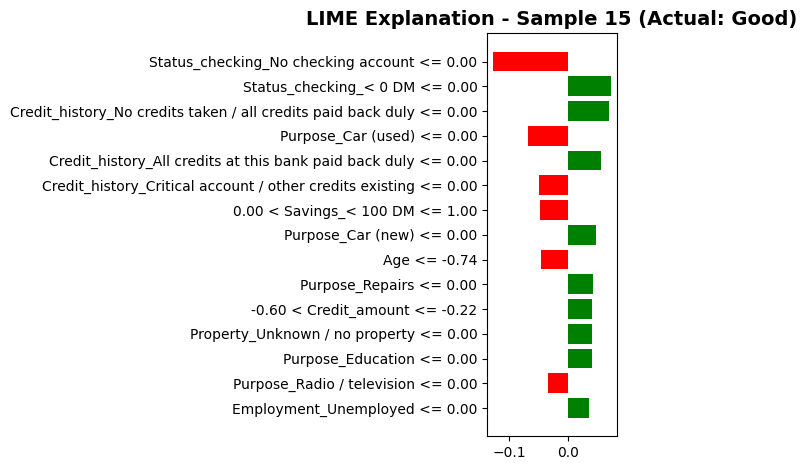

In [12]:
# With the same sample index as before (ie sample_idx)
# Generating LIME explanation
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_transformed[sample_idx],
    predict_fn=rf_model.predict_proba,
    num_features=15,
    num_samples=5000
)
print(f"Sample number {sample_idx}")
print(f"Actual label: {y_test[sample_idx]}")
print(f"Model prediction: {rf_model.predict(X_test_df.iloc[[sample_idx]])[0]}")
print(f"Prediction probability: {rf_model.predict_proba(X_test_df.iloc[[sample_idx]])[0]}")
fig = lime_exp.as_pyplot_figure()
plt.title(f'LIME Explanation - Sample {sample_idx} (Actual: {"Bad" if y_test[sample_idx]==0 else "Good"})', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

- LIME shows the lack of checking account, young age, low saving and the purpose being used car pushing the prediction towards bad credit and positive credit history and amount pushing it towards good credit.
- This confirms that the model's decision is driven by local financial stability signals and effects are balanced which explains why this sample lies close to decision boundary.